In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import utils
from utils import *
from __future__ import division, print_function

Using TensorFlow backend.


In [3]:
path = "data/weather/"
model_path = path + 'models/'
batch_size=1024

In [267]:
data = pd.read_csv(path + 'all_data.csv', index_col='DateUTC', parse_dates=True, usecols=['DateUTC','TemperatureF','DewpointF','PressureIn','WindSpeedMPH','WindSpeedGustMPH','Humidity','HourlyPrecipIn','dailyrainin','SolarRadiationWatts/m^2'])
data.index = data.index.tz_localize('UTC').tz_convert('US/Pacific')

data = data[data.TemperatureF > 0] # Remove bad temp
data = data[data.PressureIn   > 0] # Remove bad pressure
data = data[data.HourlyPrecipIn >= 0] # Remove bad rainfall

data = data.assign(forward_min = data.rolling('10h', closed='both').TemperatureF.min().shift(-1,'10h').asof(data.index))

data = data.assign(day_of_year = data.index.dayofyear, hour = data.index.hour)
data = data.assign(threshold = 'no')
data.loc[data.forward_min < 32,'threshold'] = '32'

data = data.merge(pd.get_dummies(data.threshold, prefix='threshold'), left_index=True, right_index=True)

data.head()

,TemperatureF,DewpointF,PressureIn,WindSpeedMPH,WindSpeedGustMPH,Humidity,HourlyPrecipIn,dailyrainin,SolarRadiationWatts/m^2,forward_min,day_of_year,hour,threshold,threshold_32,threshold_no
DateUTC,,,,,,,,,,,,,,,
2016-02-16 11:12:00-08:00,73.8,50.5,29.29,0.0,0.0,44,0.0,0.0,17.48,73.8,47,11,no,0,1
2016-02-16 11:14:00-08:00,74.5,50.5,29.29,0.0,0.0,43,0.0,0.0,17.48,73.8,47,11,no,0,1
2016-02-16 11:15:00-08:00,74.5,50.5,29.28,0.0,0.0,43,0.0,0.0,17.48,73.8,47,11,no,0,1
2016-02-16 11:16:00-08:00,74.5,50.5,29.27,0.0,0.0,43,0.0,0.0,17.53,73.8,47,11,no,0,1
2016-02-16 11:18:00-08:00,74.5,50.5,29.28,0.0,0.0,43,0.0,0.0,17.48,73.8,47,11,no,0,1


In [219]:
minutes_in_week = 60*24*7+30
seq_length=15
base = 30
multiple = np.exp(np.log(minutes_in_week/base)/(seq_length-1))
fp_fn_ratio=10

In [255]:
from pandas.tseries.offsets import *

offsets = pd.Series(DateOffset(minutes = base*(multiple**i-1)) for i in range(seq_length-1,-1,-1))
wanted_cols = data[['TemperatureF','DewpointF','PressureIn','WindSpeedMPH','WindSpeedGustMPH','Humidity','HourlyPrecipIn','dailyrainin','SolarRadiationWatts/m^2','day_of_year', 'hour']]

# TODO: This below takes AN HOUR to run on 124,028 data points.  Surely that could be faster??!?
all_x = np.nan_to_num([wanted_cols.asof(idx - offsets).values for idx, _ in wanted_cols.iterrows()])
all_y = data[['threshold_32']]
save_array(path+'all_x', all_x)
save_array(path+'all_y', all_y)

# all_x = load_array(path+'all_x')
# all_y = load_array(path+'all_y')

all_x.shape, all_y.shape

(1000, 15, 11)

In [7]:
train_idx = np.where(data.day_of_year%10!=0)
val_idx = np.where(data.day_of_year%10==0)

train_x, train_y = all_x[train_idx], all_y[train_idx]
val_x, val_y = all_x[val_idx], all_y[val_idx]

train_data = data.iloc[train_idx]
validation_data = data.iloc[val_idx]

In [8]:
train_idx[0].size, train_y.shape, val_idx[0].size, val_y.shape, train_idx[0].size+val_idx[0].size, len(data)

(112005, (112005, 1), 12023, (12023, 1), 124028, 124028)

In [9]:
model = Sequential([
    BatchNormalization(input_shape=(seq_length, train_x.shape[2])),
    Dropout(0.25),
    
    Conv1D(128, 3, padding='causal', activation='relu'),
    BatchNormalization(),
    Conv1D(128, 3, padding='causal', activation='relu'),
    MaxPooling1D(),
    BatchNormalization(),

    Conv1D(256, 3, padding='same', activation='relu'),
    BatchNormalization(),
    Conv1D(256, 3, padding='same', activation='relu'),
    MaxPooling1D(),
    BatchNormalization(),

#     Conv1D(512, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     Conv1D(512, 3, padding='same', activation='relu'),
#     BatchNormalization(),
#     MaxPooling1D(4),
    
    Flatten(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    
    Dropout(0.75),
    Dense(train_y.shape[1], activation='sigmoid'),
])
model.compile(Nadam(), 'binary_crossentropy', ['binary_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 5, 11)             44        
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 11)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 128)            4352      
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 128)            512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 128)            49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 2, 128)            512       
__________

In [10]:
callback = ReduceLROnPlateau(patience=2, verbose=1, monitor='loss')

model.fit(train_x, train_y,
          epochs=20,
          batch_size=batch_size,
          validation_data=(val_x, val_y),
          class_weight={0:1, 1:fp_fn_ratio},
          callbacks=[callback])

Train on 112005 samples, validate on 12023 samples
Epoch 1/20
112005/112005 [==============================] - 5s - loss: 0.5838 - binary_accuracy: 0.8686 - val_loss: 6.8606 - val_binary_accuracy: 0.0724
Epoch 2/20
112005/112005 [==============================] - 3s - loss: 0.2686 - binary_accuracy: 0.9406 - val_loss: 8.2920 - val_binary_accuracy: 0.1360
Epoch 3/20
112005/112005 [==============================] - 3s - loss: 0.2046 - binary_accuracy: 0.9538 - val_loss: 3.4802 - val_binary_accuracy: 0.3853
Epoch 4/20
112005/112005 [==============================] - 3s - loss: 0.1713 - binary_accuracy: 0.9610 - val_loss: 0.1419 - val_binary_accuracy: 0.9460
Epoch 5/20
112005/112005 [==============================] - 3s - loss: 0.1518 - binary_accuracy: 0.9659 - val_loss: 0.0824 - val_binary_accuracy: 0.9603
Epoch 6/20
112005/112005 [==============================] - 3s - loss: 0.1414 - binary_accuracy: 0.9674 - val_loss: 0.2556 - val_binary_accuracy: 0.9369
Epoch 7/20
112005/112005 [=====

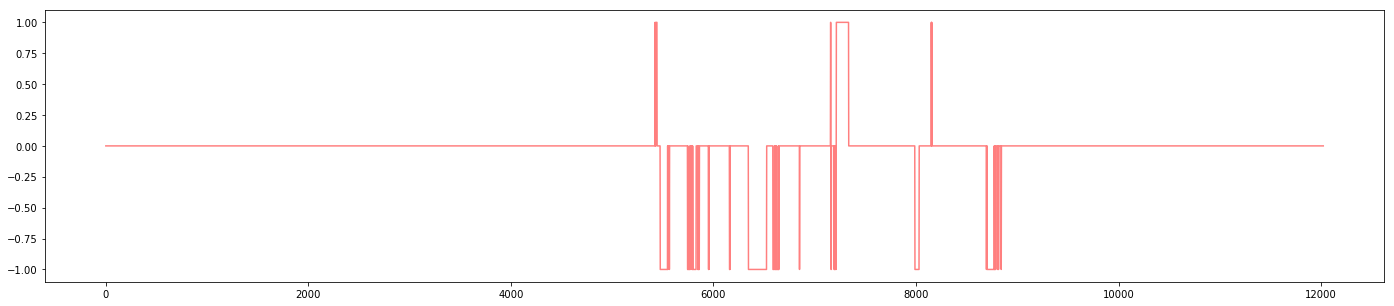

In [11]:
plt.figure(figsize=(24,5))
plt.plot(val_y-np.round(model.predict(val_x, batch_size=batch_size)), color=(1,0,0,0.5))
#plt.plot(np.round(model.predict(val_x, batch_size=batch_size)), color=(0,0,1,0.5))

In [12]:
val_pseudo = np.round(model.predict(val_x, batch_size=batch_size))
combo_x = np.concatenate((train_x, val_x))
combo_y = np.concatenate((train_y, val_pseudo))
train_x.shape, val_x.shape, combo_x.shape, train_y.shape, val_y.shape, combo_y.shape

((112005, 5, 11),
 (12023, 5, 11),
 (124028, 5, 11),
 (112005, 1),
 (12023, 1),
 (124028, 1))

In [13]:
model.fit(train_x, train_y,
          epochs=20,
          batch_size=batch_size,
          validation_data=(val_x, val_y),
          class_weight={0:1, 1:fp_fn_ratio},
          callbacks=[callback])

Train on 112005 samples, validate on 12023 samples
Epoch 1/20
112005/112005 [==============================] - 3s - loss: 0.0764 - binary_accuracy: 0.9817 - val_loss: 0.1379 - val_binary_accuracy: 0.9470
Epoch 2/20
112005/112005 [==============================] - 3s - loss: 0.0751 - binary_accuracy: 0.9824 - val_loss: 0.1069 - val_binary_accuracy: 0.9525
Epoch 3/20
112005/112005 [==============================] - 3s - loss: 0.0757 - binary_accuracy: 0.9828 - val_loss: 0.1818 - val_binary_accuracy: 0.9410
Epoch 4/20
112005/112005 [==============================] - 3s - loss: 0.0705 - binary_accuracy: 0.9833 - val_loss: 0.1754 - val_binary_accuracy: 0.9448
Epoch 5/20
112005/112005 [==============================] - 3s - loss: 0.0667 - binary_accuracy: 0.9841 - val_loss: 0.1960 - val_binary_accuracy: 0.9364
Epoch 6/20
112005/112005 [==============================] - 3s - loss: 0.0674 - binary_accuracy: 0.9848 - val_loss: 0.1924 - val_binary_accuracy: 0.9315
Epoch 7/20
112005/112005 [=====

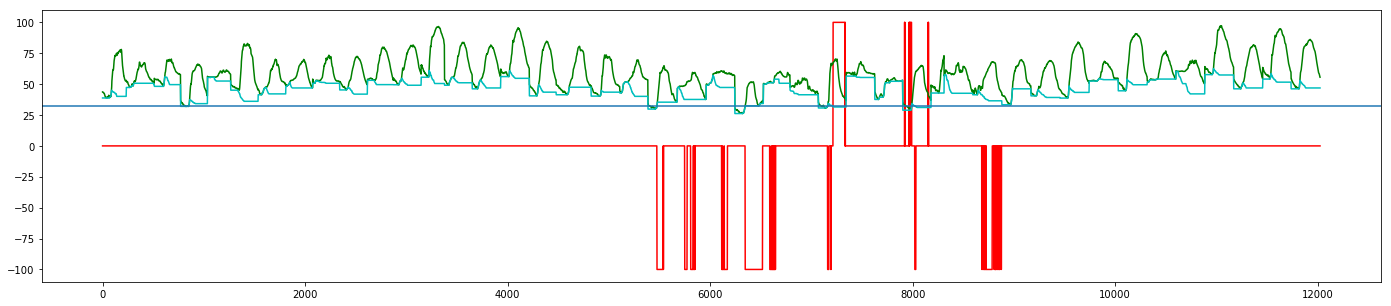

In [14]:
plt.figure(figsize=(24,5))
plt.plot((val_y-np.round(model.predict(val_x, batch_size=batch_size)))*100, 'r')
plt.plot(validation_data.TemperatureF.as_matrix(), 'g')
plt.plot(validation_data.forward_min.as_matrix(), 'c')
plt.axhline(32)

In [141]:
prediction_data = validation_data.assign(prediction = np.round(model.predict(val_x, batch_size=batch_size)).astype(int))
prediction_data.index = prediction_data.index.tz_convert('UTC')
prediction_data = prediction_data.merge(pd.get_dummies(prediction_data.prediction, prefix='prediction'), left_index=True, right_index=True)
prediction_data = prediction_data.assign(fn = prediction_data.threshold_32*prediction_data.prediction_0)
prediction_data = prediction_data.assign(fp = prediction_data.threshold_no*prediction_data.prediction_1)

In [165]:
resample = '8H'
extract = prediction_data.TemperatureF.resample(resample).min().to_frame().merge(prediction_data.forward_min.resample(resample).min().to_frame(), left_index=True, right_index=True).merge(prediction_data.threshold_32.resample(resample).max().to_frame(), left_index=True, right_index=True).merge(prediction_data.prediction_1.resample(resample).max().to_frame(), left_index=True, right_index=True).merge(prediction_data.fn.resample(resample).prod().to_frame(), left_index=True, right_index=True).merge(prediction_data.fp.resample(resample).prod().to_frame(), left_index=True, right_index=True)
extract.fp = extract.fp * 32
extract.fn = extract.fn * 32
extract.fp[extract.fp==0] = float('nan')
extract.fn[extract.fn==0] = float('nan')
extract.fn.count(), extract.fp.count()

(0, 0)

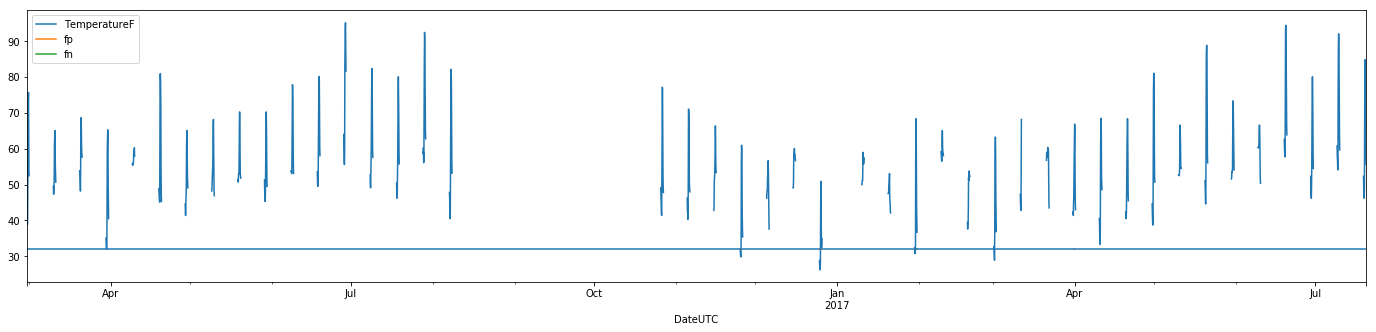

In [161]:
extract[['TemperatureF','fp', 'fn']].plot(figsize=(24,5))
plt.axhline(32)